In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder



from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV

from tpot import TPOTRegressor


from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances


import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
694,1,388.0,NaN,NaN,61.0,168.0,21.612812,127.0,75.0,0.0,68.0,0.0,NaN,NaN,NaN,NaN,0.404762,0.0,0.0,0.0,1.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,4.526550,4.483440,9.009990,NaN,NaN,3.66,5.05,8.71,0.0,0.0,0.0,5.54,3.44,1.63,0.34,0.09,0.04,62.2,29.4,6.1,1.6,0.7,4.24,13.5,38.5,2.851852,90.8,31.8,35.1,12.0,0.0,163.0,11.4,14.5,36.8,29.422383,0.088957,100.000000,4.794118,2.110429,0.294224,0.016245,139.0,4.17,9.97,NaN,0.79,NaN,11.0,16.0,NaN,175.0,4.52550,0.0,83.0,2.14638,0.0,96.0,2.482560,0.0,62.0,0.69998,0.0,1.156627,0.746988,0.537461,NaN,6.99980,4.248291,-0.126686,NaN,NaN,NaN,NaN,41.0,79.0,101.0,23.30,0.42,4.544938,17.87,0.306280,0.0,0.0,2.35,4.82,14.60,9.0,113.0,3.8,5.2,1.368421,339.0,365.0,1.16,0.334294,0.021805,457.681031,NaN,281.0,NaN,153.0,53.2,2.18,18.50,NaN,NaN,2.00,2.44,436.0,NaN,0.580000,2.0,1.0,26.0
244,1,NaN,NaN,NaN,69.0,168.0,24.447279,114.0,82.0,0.0,73.0,0.0,90.0,0.811111,0.0,1.0,0.434524,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,5.252235,3.310848,8.563083,NaN,NaN,11.52,16.16,27.68,1.0,0.0,0.0,10.02,7.52,1.52,0.85,0.04,0.05,75.0,15.2,8.5,0.4,0.5,4.46,13.4,40.0,2.985075,89.7,30.0,33.5,12.0,0.0,257.0,15.7,11.9,41.2,25.648703,0.046304,169.078947,1.788235,4.947368,0.151697,0.003992,142.0,3.82,9.73,NaN,0.70,NaN,26.0,38.0,NaN,190.0,4.91340,0.0,77.0,1.99122,0.0,111.0,2.870460,0.0,71.0,0.80159,0.0,1.441558,0.922078,0.666133,35.571429,12.02385,4.364294,-0.035232,NaN,NaN,NaN,NaN,51.0,87.0,NaN,10.40,NaN,2.2

### Handle `prolactin` outliers

In [3]:
mean = df[PROLACTIN].mean()
std = df[PROLACTIN].std()
zscore_3_threshold = mean + (3*std)

<Axes: >

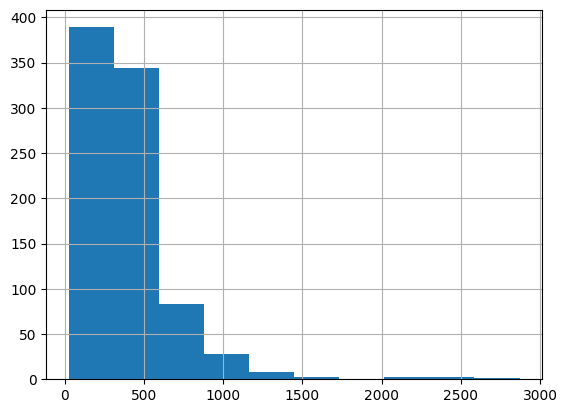

In [4]:
df[PROLACTIN].hist()

In [5]:
df[df[PROLACTIN] > zscore_3_threshold][PROLACTIN]

45     1322.0
85     1376.0
91     1511.0
309    2051.0
379    1301.0
391    2408.0
457    1240.0
489    2573.0
597    1559.0
829    2104.0
885    1422.0
893    1475.0
917    1235.0
925    2870.0
956    1315.0
Name: prolactin, dtype: float64

In [6]:
all_observations = df[PROLACTIN].notna().sum()
outlier_observations = df[df[PROLACTIN] > zscore_3_threshold][PROLACTIN].count()
print(f'Percent of outlier observations: {round((outlier_observations / all_observations)*100, 2)} %')

Percent of outlier observations: 1.74 %


In [7]:
df.loc[df[PROLACTIN] > zscore_3_threshold, PROLACTIN] = np.nan

<Axes: >

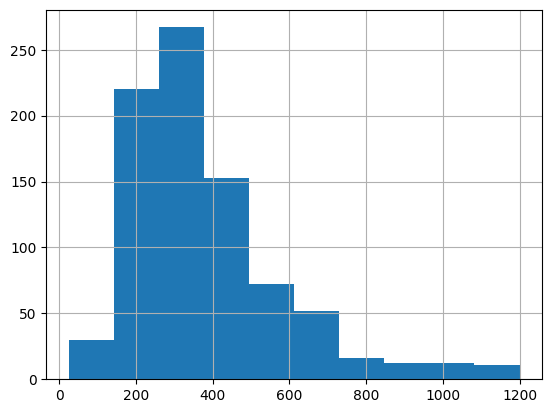

In [8]:
df[PROLACTIN].hist()

In [9]:
df_prolactin_cleaned = df.dropna(subset=[PROLACTIN])

X_prolactin, y_prolactin = df_prolactin_cleaned.drop(columns=[PROLACTIN]), df_prolactin_cleaned[PROLACTIN]
X_train_prolactin, X_test_prolactin, y_train_prolactin, y_test_prolactin = train_test_split(X_prolactin, y_prolactin, test_size=0.2, random_state=42)

### Models exploration

In [49]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]


continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}


scores_df = explore_all_variations_of_preprocessing(X_train_prolactin, y_train_prolactin, PROLACTIN, models, continuous_preprocessings, categorical_preprocessings)
scores_df

1/48 DecisionTreeRegressor(max_depth=7, random_state=42) PT_iterative_basic original_ohe_no_imputing [-166.19210821 -147.1363017  -189.64786404 -189.93558784 -175.16817069
 -186.39788636 -189.21610798 -163.15820229 -173.54463021 -148.70438725
 -169.73298576 -180.39924585 -157.40780278 -160.89618397 -197.52281334] 173.00401855184498
2/48 Lasso() PT_iterative_basic original_ohe_no_imputing [-139.8110004  -128.88491386 -137.23894418 -155.69356942 -132.11830107
 -148.11452441 -130.87812423 -137.3091251  -135.91014973 -124.14534525
 -120.30001862 -133.01587288 -127.80328357 -137.09684791 -165.13814879] 136.89721129506916
3/48 Ridge() PT_iterative_basic original_ohe_no_imputing [-165.8439677  -144.28813132 -142.65022287 -170.53734048 -138.62638404
 -160.94317113 -148.48557499 -160.00634203 -143.93937444 -156.86701973
 -142.79500229 -141.79871014 -144.46407036 -147.23891495 -181.54234269] 152.66843794390238
4/48 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-131.8316911

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,"DecisionTreeRegressor(max_depth=7, random_state=42)",173.004019
1,PT_iterative_basic,original_ohe_no_imputing,Lasso(),136.897211
2,PT_iterative_basic,original_ohe_no_imputing,Ridge(),152.668438
3,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),138.984863
4,PT_iterative_basic,original_ohe_+_impute_knn,"DecisionTreeRegressor(max_depth=7, random_state=42)",173.547287
5,PT_iterative_basic,original_ohe_+_impute_knn,Lasso(),138.872561
6,PT_iterative_basic,original_ohe_+_impute_knn,Ridge(),150.387971
7,PT_iterative_basic,original_ohe_+_impute_knn,RandomForestRegressor(),140.583226
8,PT_iterative_basic,original_ohe_+_impute_rf,"DecisionTreeRegressor(max_depth=7, random_state=42)",175.534547
9,PT_iterative_basic,original_ohe_+_impute_rf,Lasso(),138.099032


In [56]:
scores_df[scores_df['model']=="Lasso()"].groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    139.125814
                          original_ohe_+_impute_rf     137.307175
                          original_ohe_no_imputing     137.157919
PT_iterative_basic        original_ohe_+_impute_knn    138.872561
                          original_ohe_+_impute_rf     138.099032
                          original_ohe_no_imputing     136.897211
RS_KNN                    original_ohe_+_impute_knn    145.082688
                          original_ohe_+_impute_rf     143.709231
                          original_ohe_no_imputing     142.118578
RS_iterative_basic        original_ohe_+_impute_knn    146.810933
                          original_ohe_+_impute_rf     144.791703
                          original_ohe_no_imputing     144.177588
Name: MAE, dtype: float64

In [57]:
scores_df[scores_df['model']=="RandomForestRegressor()"].groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    141.451367
                          original_ohe_+_impute_rf     141.317026
                          original_ohe_no_imputing     138.876687
PT_iterative_basic        original_ohe_+_impute_knn    140.583226
                          original_ohe_+_impute_rf     141.660030
                          original_ohe_no_imputing     138.984863
RS_KNN                    original_ohe_+_impute_knn    142.397093
                          original_ohe_+_impute_rf     141.490946
                          original_ohe_no_imputing     141.032960
RS_iterative_basic        original_ohe_+_impute_knn    140.773417
                          original_ohe_+_impute_rf     139.704389
                          original_ohe_no_imputing     139.427789
Name: MAE, dtype: float64

In [58]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    152.576680
                          original_ohe_+_impute_rf     150.515483
                          original_ohe_no_imputing     150.303209
PT_iterative_basic        original_ohe_+_impute_knn    150.847761
                          original_ohe_+_impute_rf     150.677804
                          original_ohe_no_imputing     150.388633
RS_KNN                    original_ohe_+_impute_knn    157.857824
                          original_ohe_+_impute_rf     157.870328
                          original_ohe_no_imputing     158.220550
RS_iterative_basic        original_ohe_+_impute_knn    156.013863
                          original_ohe_+_impute_rf     154.918352
                          original_ohe_no_imputing     155.214571
Name: MAE, dtype: float64

Best combo: 

In [46]:
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])
tree_continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])

# continuous_preprocessor = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=9))])

categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

### Lasso

Fitting 15 folds for each of 8 candidates, totalling 120 fits


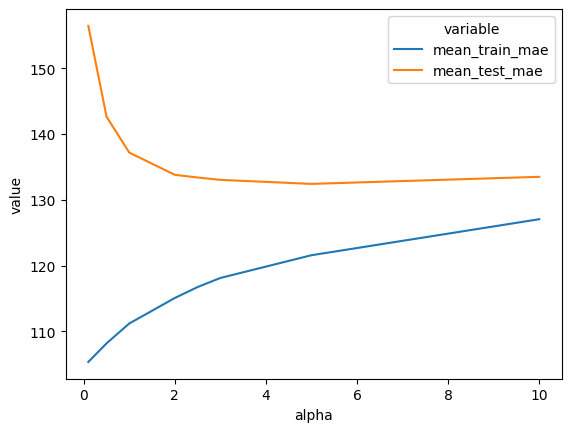

,alpha,mean_train_mae,mean_test_mae
0,0.1,105.350209,156.416496
1,0.5,108.172300,142.622043
2,1,111.193689,137.157919
3,2,115.070814,133.784092
4,2.5,116.733365,133.379921
5,3,118.110251,133.019551
6,5,121.567414,132.407890
7,10,127.038454,133.482673


In [16]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.1, 0.5, 1, 2, 2.5, 3, 5, 10],
    }

prolactin_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
prolactin_lasso_model_hyperparam_tuning_df

Chosen alpha: 2

### Ridge

Fitting 15 folds for each of 6 candidates, totalling 90 fits


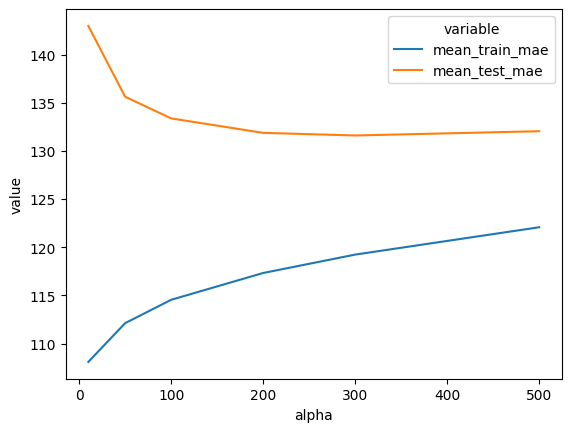

,alpha,mean_train_mae,mean_test_mae
0,10,108.104635,142.972337
1,50,112.126221,135.625787
2,100,114.551525,133.376907
3,200,117.332797,131.875968
4,300,119.242352,131.602389
5,500,122.079614,132.045416


In [19]:
ridge_param_grid = {
    "model__alpha": [10, 50, 100, 200, 300, 500],
    }

prolactin_ridge_model_hyperparam_tuning_df =  hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
prolactin_ridge_model_hyperparam_tuning_df

Chosen alpha: 100

### Decision Tree Regressor

In [89]:
tree_param_grid = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [7, 10, 15, 20, 25, 30],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_prolactin, y_train_prolactin, PROLACTIN, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, tree_param_grid)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


,params,mean_train_mae,mean_test_mae
46,"{'model__criterion': 'absolute_error', 'model__max_depth': 30, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",118.772749,141.538580
34,"{'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",119.152383,142.766080
42,"{'model__criterion': 'absolute_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",118.813298,142.829139
39,"{'model__criterion': 'absolute_error', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",119.585455,143.131630
27,"{'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",119.421653,143.444539
30,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",119.309915,143.462271
38,"{'model__criterion': 'absolute_error', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",118.887667,143.549399
31,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",118.850801,143.821541
26,"{'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",119.965071,144.142315
43,"{'model__criterion': 'absolute_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",117.832758,144.845837


In [ ]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=15, min_samples_leaf=20, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_prolactin, y_train_prolactin, model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

In [90]:
param_grid_rf = {
    'model__criterion': ['absolute_error'],
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [None],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [3, 5, 10, 15],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_prolactin, y_train_prolactin, PROLACTIN, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 48 candidates, totalling 720 fits


,params,mean_train_mae,mean_test_mae
17,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 200}",106.691362,132.739884
19,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 5, 'model__n_estimators': 200}",113.490329,132.744639
16,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 100}",106.751302,132.836743
23,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 200}",113.482256,133.018744
12,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}",106.822118,133.028398
21,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 200}",113.439099,133.061736
22,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 100}",113.367610,133.079064
13,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}",106.640264,133.082615
20,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 100}",113.444833,133.083857
18,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 5, 'model__n_estimators': 100}",113.690313,133.215110


In [95]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=10, min_samples_split=15, criterion='absolute_error')

tuned_df = compare_random_states(X_train_prolactin, y_train_prolactin, rf_model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:47<00:00,  5.93s/it]


,cv_mae
77,-131.976783
13,-131.980574
51,-132.062907
76,-132.249041
27,-132.250816


## Best models for prolactin

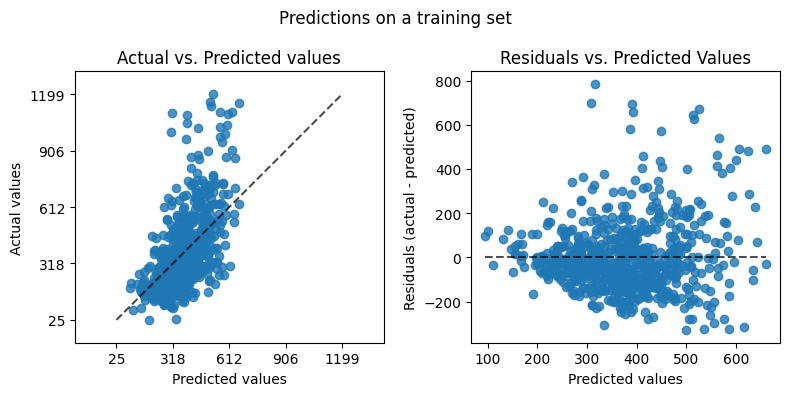

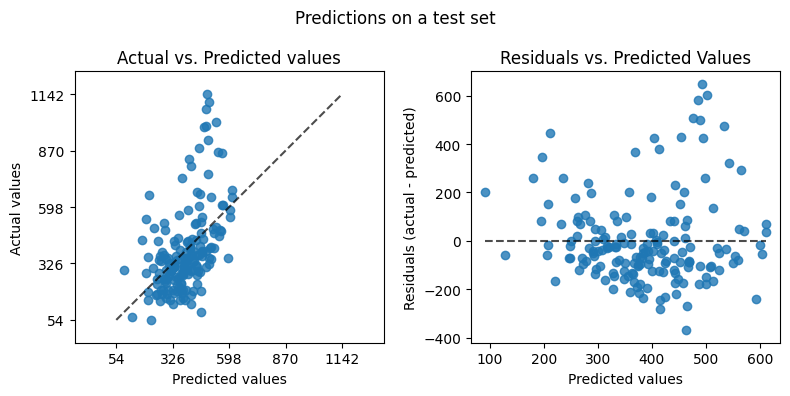

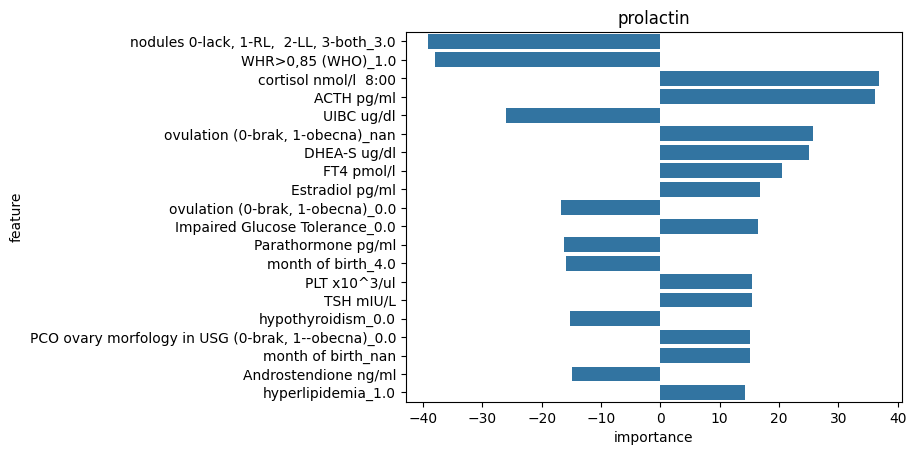

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=2),training,25938.812,117.503,161.055,0.340
1,Lasso(alpha=2),test,32952.349,131.769,181.528,0.246


In [32]:
lasso_model = Lasso(alpha=2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

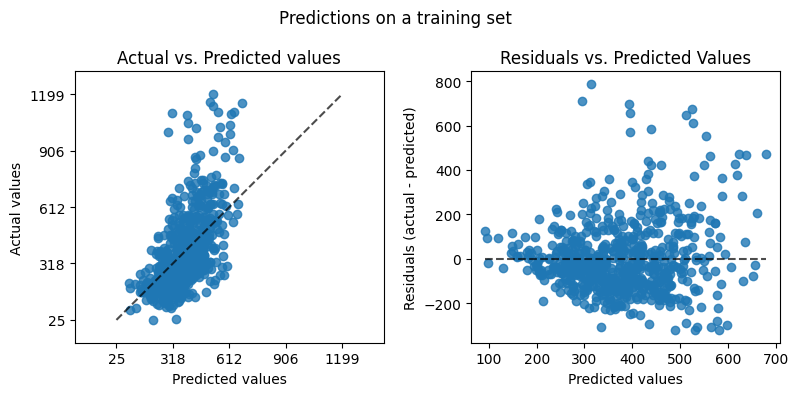

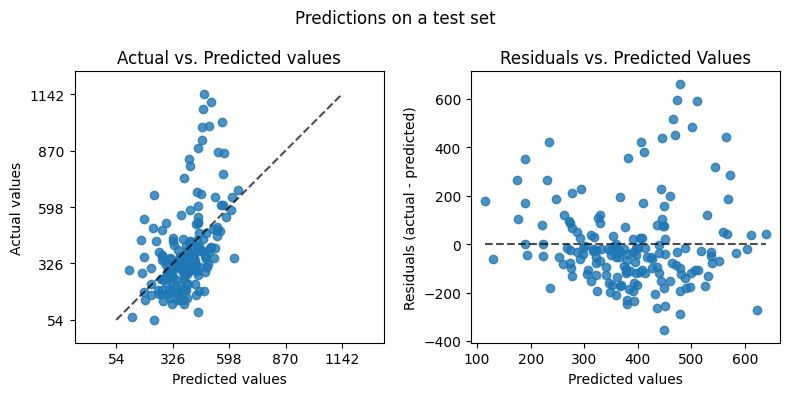

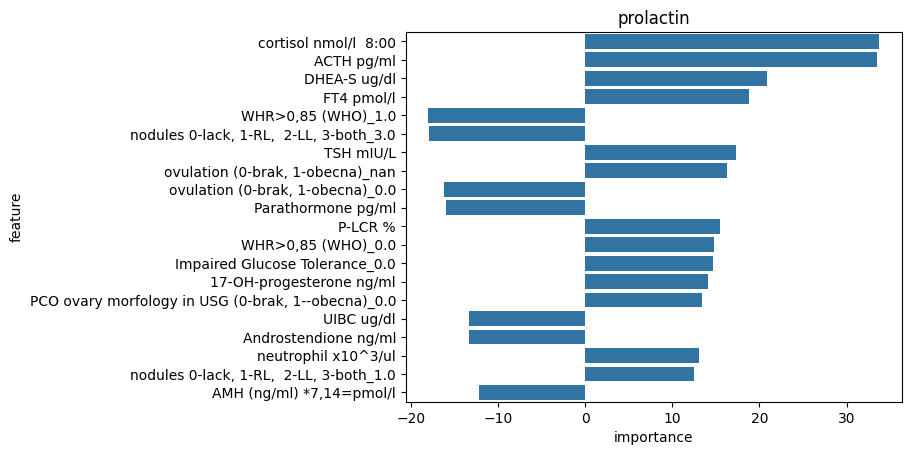

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=100),training,25225.753,115.910,158.826,0.358
1,Ridge(alpha=100),test,33259.399,132.665,182.372,0.239


In [33]:
ridge_model = Ridge(alpha=100)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

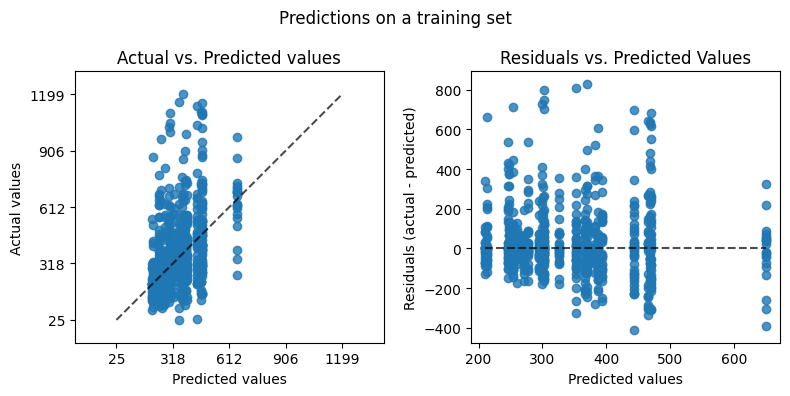

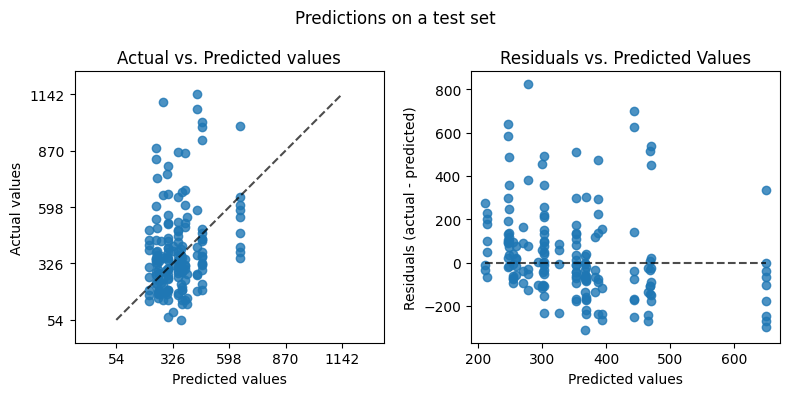

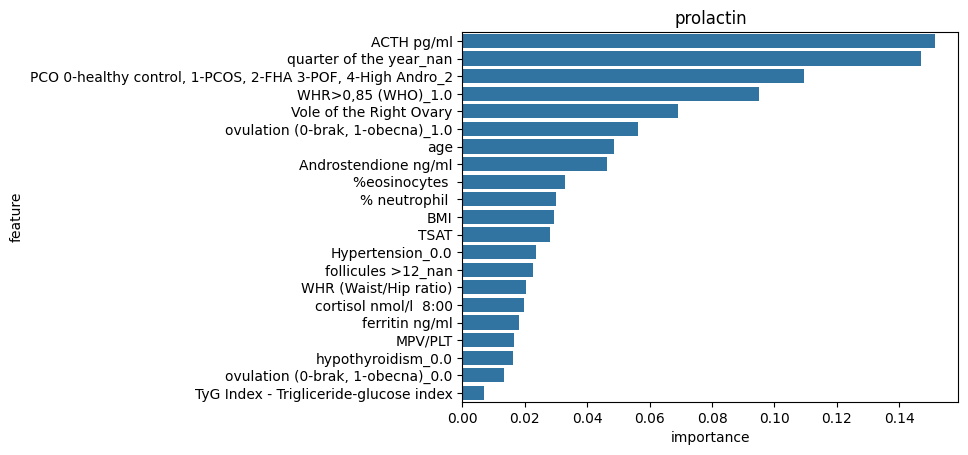

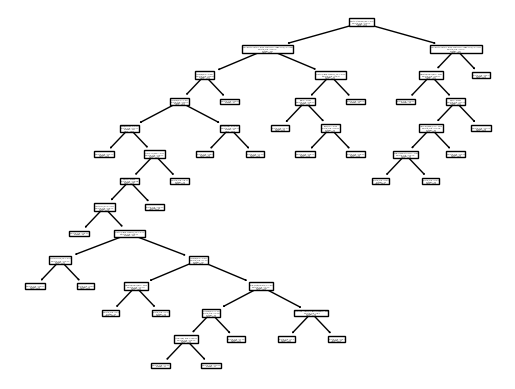

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=15,\n min_samples_leaf=20, min_samples_split=15,\n random_state=54, splitter='random')",training,32900.396,118.939,181.385,0.162
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=15,\n min_samples_leaf=20, min_samples_split=15,\n random_state=54, splitter='random')",test,44975.249,150.278,212.074,-0.029


In [47]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=15, min_samples_leaf=20, min_samples_split=15, splitter='random', random_state=54)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

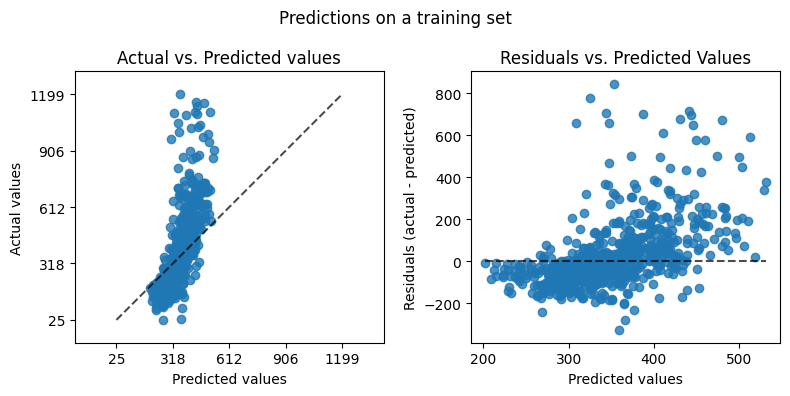

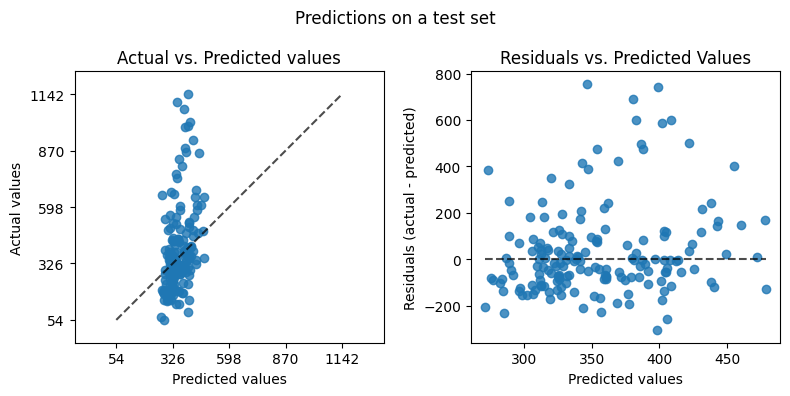

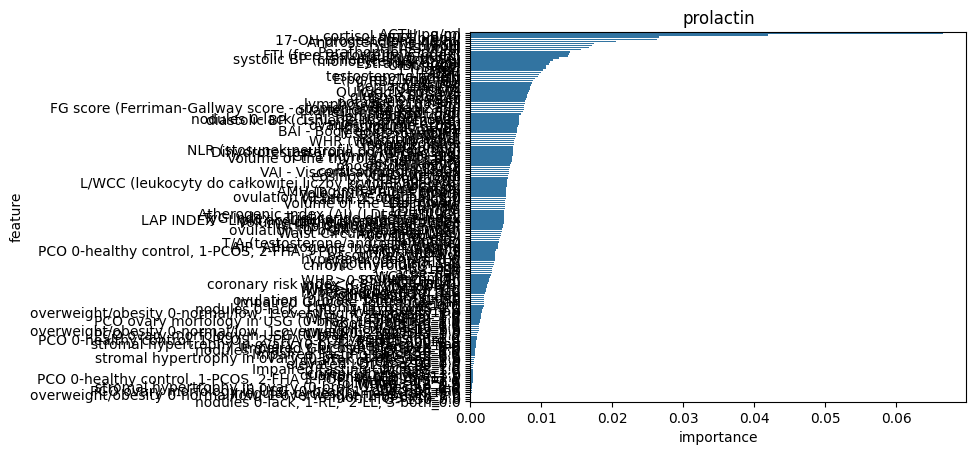

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=10, min_samples_split=15,\n random_state=77)",training,26196.801,106.021,161.854,0.333
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=10, min_samples_split=15,\n random_state=77)",test,39119.118,133.359,197.786,0.105


In [48]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=10, min_samples_split=15, criterion='absolute_error', random_state=77)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

## Feature importances

In [36]:
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])


ranked_df = rank_importances(feature_importance_df)
ranked_df.head()

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
0,HDL mg/dl,82.0,206.0,24.0,118.0,107.50
1,% lymphocytes,29.0,29.0,24.0,98.0,45.00
2,% monocytes,21.0,28.0,24.0,90.0,40.75
3,% neutrophil,82.0,119.0,24.0,103.0,82.00
4,%basophils,82.0,164.0,24.0,124.0,98.50


In [37]:
ranked_df.sort_values(by='lasso_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
188,"nodules 0-lack, 1-RL, 2-LL, 3-both_3.0",1.0,6.0,24.0,143.0,43.50
117,"WHR>0,85 (WHO)_1.0",2.0,5.0,4.0,95.0,26.50
134,cortisol nmol/l 8:00,3.0,1.0,1.0,2.0,1.75
7,ACTH pg/ml,4.0,2.0,2.0,1.0,2.25
102,UIBC ug/dl,5.0,16.0,24.0,15.0,15.00
197,"ovulation (0-brak, 1-obecna)_nan",6.0,8.0,24.0,78.0,29.00
25,DHEA-S ug/dl,7.0,3.0,24.0,14.0,12.00
32,FT4 pmol/l,8.0,4.0,24.0,8.0,11.00
28,Estradiol pg/ml,9.0,24.0,24.0,12.0,17.25
195,"ovulation (0-brak, 1-obecna)_0.0",10.0,9.0,3.0,105.0,31.75


In [38]:
ranked_df.sort_values(by='ridge_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
134,cortisol nmol/l 8:00,3.0,1.0,1.0,2.0,1.75
7,ACTH pg/ml,4.0,2.0,2.0,1.0,2.25
25,DHEA-S ug/dl,7.0,3.0,24.0,14.0,12.00
32,FT4 pmol/l,8.0,4.0,24.0,8.0,11.00
117,"WHR>0,85 (WHO)_1.0",2.0,5.0,4.0,95.0,26.50
188,"nodules 0-lack, 1-RL, 2-LL, 3-both_3.0",1.0,6.0,24.0,143.0,43.50
99,TSH mIU/L,15.0,7.0,24.0,17.0,15.75
197,"ovulation (0-brak, 1-obecna)_nan",6.0,8.0,24.0,78.0,29.00
195,"ovulation (0-brak, 1-obecna)_0.0",10.0,9.0,3.0,105.0,31.75
84,Parathormone pg/ml,12.0,10.0,24.0,7.0,13.25


In [39]:
ranked_df.sort_values(by='tree_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
134,cortisol nmol/l 8:00,3.0,1.0,1.0,2.0,1.75
7,ACTH pg/ml,4.0,2.0,2.0,1.0,2.25
195,"ovulation (0-brak, 1-obecna)_0.0",10.0,9.0,3.0,105.0,31.75
117,"WHR>0,85 (WHO)_1.0",2.0,5.0,4.0,95.0,26.50
166,"irregular cycles (0-nie, 1-tak)_1.0",82.0,178.0,5.0,162.0,106.75
16,BAI - Body adiposity index,82.0,105.0,6.0,25.0,54.50
24,CRP mg/l,70.0,93.0,7.0,70.0,60.00
6,17-OH-progesterone ng/ml,25.0,14.0,8.0,3.0,12.50
12,Androstendione ng/ml,19.0,17.0,9.0,11.0,14.00
74,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro_2",82.0,61.0,10.0,111.0,66.00


In [40]:
ranked_df.sort_values(by='rf_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
7,ACTH pg/ml,4.0,2.0,2.0,1.0,2.25
134,cortisol nmol/l 8:00,3.0,1.0,1.0,2.0,1.75
6,17-OH-progesterone ng/ml,25.0,14.0,8.0,3.0,12.50
31,FT3 pmol/l,46.0,58.0,24.0,4.0,33.00
62,LH/FSH,45.0,72.0,24.0,5.0,36.50
210,systolic BP (ciśnienie skurczowe),82.0,170.0,24.0,6.0,70.50
84,Parathormone pg/ml,12.0,10.0,24.0,7.0,13.25
32,FT4 pmol/l,8.0,4.0,24.0,8.0,11.00
61,LH,82.0,173.0,24.0,9.0,72.00
164,insulin 0 uU/ml,28.0,73.0,24.0,10.0,33.75


In [41]:
ranked_df.sort_values(by='average_rank').head(15)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
134,cortisol nmol/l 8:00,3.0,1.0,1.0,2.0,1.75
7,ACTH pg/ml,4.0,2.0,2.0,1.0,2.25
32,FT4 pmol/l,8.0,4.0,24.0,8.0,11.00
25,DHEA-S ug/dl,7.0,3.0,24.0,14.0,12.00
6,17-OH-progesterone ng/ml,25.0,14.0,8.0,3.0,12.50
84,Parathormone pg/ml,12.0,10.0,24.0,7.0,13.25
12,Androstendione ng/ml,19.0,17.0,9.0,11.0,14.00
102,UIBC ug/dl,5.0,16.0,24.0,15.0,15.00
99,TSH mIU/L,15.0,7.0,24.0,17.0,15.75
28,Estradiol pg/ml,9.0,24.0,24.0,12.0,17.25


## Feature selection methods

In [42]:
selector = VarianceThreshold(threshold=0.009)
selector.set_output(transform='pandas')
selector.fit_transform(X_train_prolactin)

kept_features_mask = selector.get_support()

print("Usunięte cechy:", [X_train_prolactin.columns[i] for i, keep in enumerate(kept_features_mask) if not keep])

Usunięte cechy: ['WHR (Waist/Hip ratio)', 'WHTR (Waist/Height Ratio)', 'basophils x10^3/ul', 'NRBC x10^3/ul', 'MPV/PLT', 'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'eos/leukocyty', 'QUICKI (N<0,357)', 'T/SHBG', 'Testosterone/DHT']


### SelectKBest

In [43]:

def feature_selection(feature_selection_model, X_train, y_train):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, get_continuous_attributes_except(PROLACTIN)),
            ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', feature_selection_model)])

    X_new = pipeline.fit_transform(X_train, y_train)

    selected_indices = feature_selection_model.get_support(indices=True)
    selected_feature_names = [preprocessor.get_feature_names_out()[i] for i in selected_indices]
    print(selected_feature_names)

    return pd.DataFrame(X_new, columns=selected_feature_names)


feature_selection(SelectKBest(mutual_info_regression, k=10), X_train_prolactin, y_train_prolactin)


feature_selection(SelectKBest(f_regression, k=10), X_train_prolactin, y_train_prolactin)


feature_selection(SelectKBest(r_regression, k=10), X_train_prolactin, y_train_prolactin).head()

['weight', 'WBC x10^3/ul', 'hematocrit [%]', 'glucose 0 mg/dl', 'FT4 pmol/l', 'LH', 'LH/FSH', 'DHEA-S ug/dl', 'SHBG nmol/l', '17-OH-progesterone ng/ml']
['monocytes x10^3/ul', 'DHEA-S ug/dl', 'cortisol nmol/l  8:00', 'Estradiol pg/ml', 'ACTH pg/ml', '17-OH-progesterone ng/ml', 'ovulation (0-brak, 1-obecna)_0.0', 'ovulation (0-brak, 1-obecna)_nan', 'hypothyroidism_0.0', 'quarter of the year_nan']
['monocytes x10^3/ul', 'LH/FSH', 'DHEA-S ug/dl', 'cortisol nmol/l  8:00', 'Estradiol pg/ml', 'ACTH pg/ml', '17-OH-progesterone ng/ml', 'ovulation (0-brak, 1-obecna)_nan', 'month of birth_nan', 'quarter of the year_nan']


,monocytes x10^3/ul,LH/FSH,DHEA-S ug/dl,cortisol nmol/l 8:00,Estradiol pg/ml,ACTH pg/ml,17-OH-progesterone ng/ml,"ovulation (0-brak, 1-obecna)_nan",month of birth_nan,quarter of the year_nan
0,0.274426,0.721828,1.701396,1.462913,1.100236,2.803717,1.141106,1.0,1.0,1.0
1,-0.049565,0.952914,0.850395,0.717683,0.927525,1.039672,0.625339,1.0,1.0,1.0
2,0.628308,0.841405,0.263762,-0.040469,-0.209291,0.341443,0.289924,0.0,0.0,0.0
3,0.083437,-0.021253,-0.133046,-0.908883,-0.514922,-1.649971,-0.023780,0.0,0.0,0.0
4,-0.554570,0.050274,-1.440936,-0.204022,2.086669,-1.495004,-1.506927,0.0,0.0,0.0


### Recursive feature elimination

Optimal number of features: 46
['neutrophil x10^3/ul' '% lymphocytes ' '% monocytes' 'P-LCR %' 'PLT/WBC'
 'AST U/l' 'TG mmol/l' 'LAP INDEX - Lipid accumulation product index'
 'UIBC ug/dl' 'glucose 0 mg/dl' 'insulin 0 uU/ml' 'Matsuda' 'TSH mIU/L'
 'FT4 pmol/l' 'DHEA-S ug/dl' 'Parathormone pg/ml' 'cortisol nmol/l  8:00'
 'cortisol nmol/l 18:00' 'Estradiol pg/ml' 'ACTH pg/ml'
 'Androstendione ng/ml' '17-OH-progesterone ng/ml'
 'T/A (testosterone/androstendione)'
 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro_1'
 'WHR>0,85 (WHO)_0.0' 'WHR>0,85 (WHO)_1.0' 'WHTR>0,5_1.0'
 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity_1.0'
 'ovulation (0-brak, 1-obecna)_0.0' 'ovulation (0-brak, 1-obecna)_nan'
 'PCO ovary morfology in USG (0-brak, 1--obecna)_0.0'
 'stromal hypertrophy in ovary (0-brak, 1-obecny)_0.0' 'acne_nan'
 'hyperandrogenism_nan' 'hypothyroidism_0.0'
 'nodules 0-lack, 1-RL,  2-LL, 3-both_1.0'
 'nodules 0-lack, 1-RL,  2-LL, 3-both_3.0' 'hyperlipidemia_1.0'
 'elevat

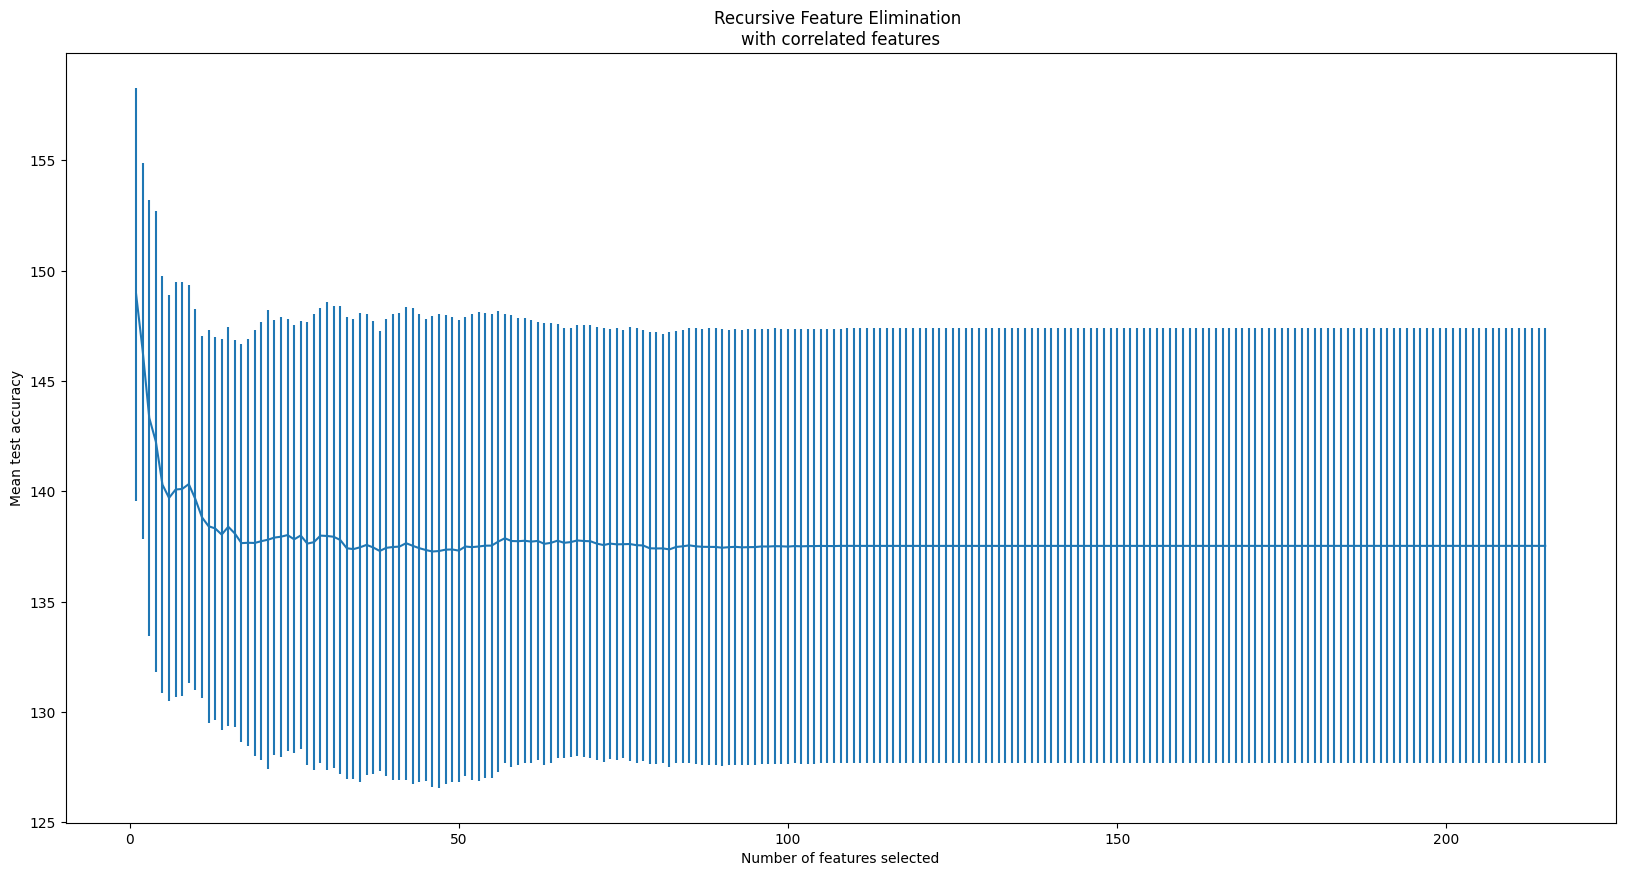

In [45]:
preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, get_continuous_attributes_except(PROLACTIN)),
        ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
    ])


min_features_to_select = 1
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
rfecv = RFECV(
    estimator=Lasso(),
    step=1,
    cv=cv,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('fs', rfecv)])
pipeline.fit(X_train_prolactin, y_train_prolactin)

selected_feature_indices = rfecv.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]

# print(len(preprocessor.get_feature_names_out()))
print(f"Optimal number of features: {rfecv.n_features_}")
# print(rfecv.get_feature_names_out())
print(selected_feature_names)

n_scores = len(rfecv.cv_results_["mean_test_score"])
scores = abs(rfecv.cv_results_["mean_test_score"])

plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### SelectFromModel

In [ ]:
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
sel_from_model = SelectFromModel(
    estimator=Lasso(),
)

pipeline = Pipeline([('preprocessor', preprocessor), ('sel_from_model', sel_from_model)])
pipeline.fit(X_train_prolactin, y_train_prolactin)

selected_feature_indices = sel_from_model.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
selected_feature_names

array(['IGF-1 ng/ml (N: 100-311)', 'proBNP', 'AMH (ng/ml) *7,14=pmol/l',
       'weight', 'height (cm)', 'diastolic BP (ciśnienie rozskurczowe)',
       'WHR (Waist/Hip ratio)',
       'FG score (Ferriman-Gallway score - stopień androgenizacji)',
       'Volume of the thyroid  Left Lobe', 'Volume of the  Left Ovary',
       'ovaries volume - total', 'WBC x10^3/ul', 'lymphocytes x10^3/ul',
       'eosinocytes x10^3/ul', 'basophils x10^3/ul', '% lymphocytes ',
       '%basophils ', 'Hemoglobin [g/dl]', 'HTC/Hb', 'MCV fl',
       'NRBC x10^3/ul', 'PLT x10^3/ul', 'PDW fl', 'MPV fl', 'P-LCR %',
       'PLT/WBC', 'MPV/PLT', 'PLR', 'limf/mono',
       'NLR (stosunek neutrofili do limfocytów)', 'potassium mmol/l',
       'calcium mg/dl', 'phosphorus mg/dl', 'creatinine mg/dl',
       'CRP mg/l', 'ALT U/l', 'AST U/l', 'Bilirubin mg/dl', 'CHOL mg/dl ',
       ' HDL mg/dl', 'TG', 'AIP -Atherogenic index of plasma',
       'UIBC ug/dl', 'TIBC', 'ferritin ng/ml', 'glucose 0 mg/dl',
       'glucose 

### TPOT

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='r2', n_jobs=-1)
tpot.fit(X_train_prolactin, y_train_prolactin)

print(tpot.fitted_pipeline_)

print("Score on test set:", tpot.score(X_test_prolactin, y_test_prolactin))

tpot.export('tpot_pipeline.py')

In [ ]:

cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='neg_mean_absolute_error', n_jobs=-1)
tpot.fit(X_train_prolactin, y_train_prolactin)

# Wyświetlenie najlepszego znalezionego rurociągu
print(tpot.fitted_pipeline_)

# Ocena modelu na zbiorze testowym
print("Score on test set:", tpot.score(X_test_prolactin, y_test_prolactin))

# Eksportowanie optymalnego rurociągu do pliku Pythona
tpot.export('tpot_pipeline.py')